# 1.NSCLC Sex-stratified SC Analysis

## Data selection, pseudobulk, create input for DESEQ2

In [1]:
import warnings
import numpy as np
import pandas as pd 
import scanpy as sc
#import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
#import altair as alt
#import pertpy as pt
#from pandas.api.types import is_categorical_dtype
#from pandas import CategoricalDtype

In [2]:
import decoupler as dc

In [109]:
#Set result directory for figures
resDir = "/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/011_analysis_paired_remove_xy/figures/"
sc.settings.figdir = resDir

In [3]:
dc.__version__

'1.5.0'

In [4]:
path = "/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp"
input_path    = f"{path}/data/local.h5ad"

In [5]:
adata = sc.read_h5ad(input_path) 

In [6]:
adata.obs.dataset.value_counts()

dataset
Kim_Lee_2020                                        175526
Adams_Kaminski_2020                                 131092
Leader_Merad_2021_10x_3p_v2_beads                   121265
UKIM-V-2                                            102115
Chen_Zhang_2020                                      93035
He_Fan_2021                                          88876
Leader_Merad_2021_10x_3p_v2_digest-deadcell_cite     68436
Leader_Merad_2021_10x_3p_v2_beads_cite               62468
Wu_Zhou_2021                                         58981
Madissoon_Meyer_2020                                 46116
Lambrechts_Thienpont_2018_6149v2                     40141
Habermann_Kropski_2020                               36727
Goveia_Carmeliet_2020                                36368
Reyfman_Misharin_2018                                34535
Laughney_Massague_2020                               26403
Zilionis_Klein_2019                                  25652
Lambrechts_Thienpont_2018_6653                  

In [7]:
nsclc_chrom = pd.read_csv(f"{path}/out/007_re_analysis/tables/input/adata_var_nsclc_chrom.csv")

In [8]:
adata

AnnData object with n_obs × n_vars = 1283972 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts'

In [9]:
adata.obs.disease.value_counts()

disease
lung adenocarcinoma                      704834
normal                                   212889
squamous cell lung carcinoma             190199
non-small cell lung carcinoma            120796
chronic obstructive pulmonary disease     55254
Name: count, dtype: int64

In [10]:
adata.obs.tumor_stage.value_counts()

tumor_stage
early         725412
advanced      288981
non-cancer    268143
Name: count, dtype: int64

In [11]:
adata.obs.sex.value_counts()

sex
male       676587
female     571042
unknown     36343
Name: count, dtype: int64

In [12]:
adata.obs.origin.value_counts()

origin
tumor_primary       585138
normal_adjacent     345211
normal              281363
tumor_metastasis     71272
nan                    988
Name: count, dtype: int64

In [13]:
adata.obs.dataset.value_counts()

dataset
Kim_Lee_2020                                        175526
Adams_Kaminski_2020                                 131092
Leader_Merad_2021_10x_3p_v2_beads                   121265
UKIM-V-2                                            102115
Chen_Zhang_2020                                      93035
He_Fan_2021                                          88876
Leader_Merad_2021_10x_3p_v2_digest-deadcell_cite     68436
Leader_Merad_2021_10x_3p_v2_beads_cite               62468
Wu_Zhou_2021                                         58981
Madissoon_Meyer_2020                                 46116
Lambrechts_Thienpont_2018_6149v2                     40141
Habermann_Kropski_2020                               36727
Goveia_Carmeliet_2020                                36368
Reyfman_Misharin_2018                                34535
Laughney_Massague_2020                               26403
Zilionis_Klein_2019                                  25652
Lambrechts_Thienpont_2018_6653                  

### 01.SELECT ONLY male, female & tumor, normal_adjacent

In [14]:
adata = adata[(adata.obs["disease"] != "normal") & (adata.obs["disease"] != "chronic obstructive pulmonary disease")] #exclude normal and COPD samples

In [15]:
adata = adata[adata.obs["tumor_stage"].notna()] #exclude samples without tumor stage

In [16]:
adata = adata[(adata.obs["sex"]=="male")| (adata.obs["sex"]=="female")]

In [17]:
adata = adata[(adata.obs["origin"]=="tumor_primary")| (adata.obs["origin"]=="normal_adjacent")]

In [18]:
adata.obs.disease.value_counts()

disease
lung adenocarcinoma              577317
squamous cell lung carcinoma     189044
non-small cell lung carcinoma    120796
Name: count, dtype: int64

In [19]:
adata.obs.tumor_stage.value_counts()

tumor_stage
early       672760
advanced    214397
Name: count, dtype: int64

In [20]:
adata.obs.sex.value_counts()

sex
male      500302
female    386855
Name: count, dtype: int64

In [21]:
adata.obs.origin.value_counts()

origin
tumor_primary      571045
normal_adjacent    316112
Name: count, dtype: int64

In [22]:
adata.obs.dataset.value_counts()

dataset
Leader_Merad_2021_10x_3p_v2_beads                   119829
UKIM-V-2                                            102115
Chen_Zhang_2020                                      93035
He_Fan_2021                                          88876
Kim_Lee_2020                                         86310
Leader_Merad_2021_10x_3p_v2_digest-deadcell_cite     68436
Leader_Merad_2021_10x_3p_v2_beads_cite               62468
Wu_Zhou_2021                                         58981
Lambrechts_Thienpont_2018_6149v2                     40141
Goveia_Carmeliet_2020                                36368
Zilionis_Klein_2019                                  25652
Lambrechts_Thienpont_2018_6653                       22617
UKIM-V                                               20787
Leader_Merad_2021_10x_5p_v1_CD2                      14894
Leader_Merad_2021_10x_3p_v3_beads                     9646
Leader_Merad_2021_10x_3p_v2_sort                      7922
Guo_Zhang_2018                                  

### 02.CELL TPYE RE-CLASIFICATION 

In [23]:
adata.obs.cell_type.value_counts()

cell_type
CD4-positive, alpha-beta T cell         152247
CD8-positive, alpha-beta T cell         123252
alveolar macrophage                      82844
macrophage                               78660
malignant cell                           75457
natural killer cell                      50680
B cell                                   44609
classical monocyte                       43364
regulatory T cell                        33603
plasma cell                              31876
epithelial cell of lung                  23013
CD1c-positive myeloid dendritic cell     20734
neutrophil                               18706
type II pneumocyte                       16274
vein endothelial cell                    15849
mast cell                                14361
capillary endothelial cell               10870
multi-ciliated epithelial cell            6413
non-classical monocyte                    6103
myeloid cell                              5544
fibroblast of lung                        5091
bro

In [24]:
adata.obs.cell_type_major.value_counts()

cell_type_major
T cell CD4               149343
T cell CD8               120586
Macrophage alveolar       82844
Macrophage                78660
Tumor cells               75457
NK cell                   50094
Monocyte                  49467
B cell                    44307
T cell regulatory         33603
Endothelial cell          32443
Plasma cell               30292
transitional club/AT2     22894
cDC2                      20734
Neutrophils               18706
Alveolar cell type 2      16274
Mast cell                 14361
other                     14017
Stromal                   13948
Ciliated                   6413
pDC                        3800
Alveolar cell type 1       3739
cDC1                       2097
Club                       1580
DC mature                  1498
Name: count, dtype: int64

In [25]:
cells_of_interest=['alveolar macrophage', 'neutrophil',
 'macrophage','malignant cell',
 'B cell',
  'regulatory T cell',
'CD4-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta T cell',
 'neutrophils','epithelial cell of lung','multi-ciliated epithelial cell' ]
subset_adata = adata[adata.obs["cell_type"].isin(cells_of_interest)] 


In [26]:
set(subset_adata.obs.cell_type)

{'B cell',
 'CD4-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta T cell',
 'alveolar macrophage',
 'epithelial cell of lung',
 'macrophage',
 'malignant cell',
 'multi-ciliated epithelial cell',
 'neutrophil',
 'regulatory T cell'}

In [27]:
set(subset_adata.obs.cell_type_major)

{'B cell',
 'Ciliated',
 'Macrophage',
 'Macrophage alveolar',
 'Neutrophils',
 'T cell CD4',
 'T cell CD8',
 'T cell regulatory',
 'Tumor cells',
 'other',
 'transitional club/AT2'}

In [28]:
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['epithelial cell of lung','multi-ciliated epithelial cell',], 'epithelial cell')
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['alveolar macrophage'], 'macrophage')
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['CD4-positive, alpha-beta T cell'], 'CD4+ T cell')
subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['CD8-positive, alpha-beta T cell'], 'CD8+ T cell')

/tmp/ipykernel_2915359/2170802957.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['epithelial cell of lung','multi-ciliated epithelial cell',], 'epithelial cell')
/tmp/ipykernel_2915359/2170802957.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subset_adata.obs["cell_type"]= subset_adata.obs["cell_type"].replace(['epithelial cell of lung','multi-ciliated epithelial cell',], 'epithelial cell')
/tmp/ipykernel_2915359/2170802957.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the catego

In [29]:
set(subset_adata.obs.cell_type)

{'B cell',
 'CD4+ T cell',
 'CD8+ T cell',
 'epithelial cell',
 'macrophage',
 'malignant cell',
 'neutrophil',
 'regulatory T cell'}

In [30]:
subset_adata

AnnData object with n_obs × n_vars = 638804 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts',

In [31]:
subset_adata.obs.disease.value_counts()

disease
lung adenocarcinoma              409606
squamous cell lung carcinoma     134606
non-small cell lung carcinoma     94592
Name: count, dtype: int64

In [32]:
subset_adata.obs.dataset.value_counts()

dataset
Leader_Merad_2021_10x_3p_v2_beads                   81690
UKIM-V-2                                            78529
Chen_Zhang_2020                                     72874
He_Fan_2021                                         68546
Kim_Lee_2020                                        58907
Wu_Zhou_2021                                        46321
Leader_Merad_2021_10x_3p_v2_digest-deadcell_cite    43966
Leader_Merad_2021_10x_3p_v2_beads_cite              41045
Lambrechts_Thienpont_2018_6149v2                    32373
Zilionis_Klein_2019                                 19792
Lambrechts_Thienpont_2018_6653                      16653
UKIM-V                                              16262
Goveia_Carmeliet_2020                               14630
Leader_Merad_2021_10x_5p_v1_CD2                     13419
Leader_Merad_2021_10x_3p_v3_beads                    7997
Guo_Zhang_2018                                       7157
Leader_Merad_2021_10x_3p_v2_sort                     4615
Leader

In [33]:
subset_adata.obs.dataset.value_counts()

dataset
Leader_Merad_2021_10x_3p_v2_beads                   81690
UKIM-V-2                                            78529
Chen_Zhang_2020                                     72874
He_Fan_2021                                         68546
Kim_Lee_2020                                        58907
Wu_Zhou_2021                                        46321
Leader_Merad_2021_10x_3p_v2_digest-deadcell_cite    43966
Leader_Merad_2021_10x_3p_v2_beads_cite              41045
Lambrechts_Thienpont_2018_6149v2                    32373
Zilionis_Klein_2019                                 19792
Lambrechts_Thienpont_2018_6653                      16653
UKIM-V                                              16262
Goveia_Carmeliet_2020                               14630
Leader_Merad_2021_10x_5p_v1_CD2                     13419
Leader_Merad_2021_10x_3p_v3_beads                    7997
Guo_Zhang_2018                                       7157
Leader_Merad_2021_10x_3p_v2_sort                     4615
Leader

## PAIRED SAMPLES

In [34]:
df_grouped = subset_adata.obs.groupby(["origin","donor_id"]).count()

/tmp/ipykernel_2915359/1850072068.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = subset_adata.obs.groupby(["origin","donor_id"]).count()


In [35]:
df_grouped.reset_index(inplace= True)

In [36]:
df_grouped_normal = df_grouped[df_grouped["origin"]=="normal_adjacent"]

In [37]:
df_grouped_normal = df_grouped_normal[df_grouped_normal['sample'] != 0]

In [38]:
df_grouped_tumor = df_grouped[df_grouped["origin"]=="tumor_primary"]

In [39]:
df_grouped_tumor = df_grouped_tumor[df_grouped_tumor['sample'] != 0]

In [51]:
df_grouped_tumor

,origin,donor_id,sample,uicc_stage,ever_smoker,age,dataset,ann_fine,cell_type_predicted,doublet_status,...,sex_ontology_term_id,tissue_ontology_term_id,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage
168,tumor_primary,Chen_Zhang_2020_NSCLC-1,1455,1455,0,0,1455,1455,1455,1455,...,1455,1455,1455,1455,1455,1455,1455,1455,1455,1455
169,tumor_primary,Chen_Zhang_2020_NSCLC-2,3230,3230,0,0,3230,3230,3230,3230,...,3230,3230,3230,3230,3230,3230,3230,3230,3230,3230
170,tumor_primary,Chen_Zhang_2020_NSCLC-3,6362,6362,0,0,6362,6362,6362,6362,...,6362,6362,6362,6362,6362,6362,6362,6362,6362,6362
171,tumor_primary,Chen_Zhang_2020_NSCLC-4,3531,3531,0,0,3531,3531,3531,3531,...,3531,3531,3531,3531,3531,3531,3531,3531,3531,3531
172,tumor_primary,Chen_Zhang_2020_NSCLC-5,7243,7243,0,0,7243,7243,7243,7243,...,7243,7243,7243,7243,7243,7243,7243,7243,7243,7243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,tumor_primary,Zilionis_Klein_2019_patient_3,5285,5285,0,5285,5285,5285,5285,5285,...,5285,5285,5285,5285,5285,5285,5285,5285,5285,5285
332,tumor_primary,Zilionis_Klein_2019_patient_4,3073,3073,0,3073,3073,3073,3073,3073,...,3073,3073,3073,3073,3073,3073,3073,3073,3073,3073
333,tumor_primary,Zilionis_Klein_2019_patient_5,1895,1895,0,1895,1895,1895,1895,1895,...,1895,1895,1895,1895,1895,1895,1895,1895,1895,1895
334,tumor_primary,Zilionis_Klein_2019_patient_6,2912,2912,0,2912,2912,2912,2912,2912,...,2912,2912,2912,2912,2912,2912,2912,2912,2912,2912


In [41]:
common_ids =list(set(df_grouped_normal.donor_id)& set(df_grouped_tumor.donor_id))

In [42]:
len(common_ids)

84

In [43]:
paired_adata = subset_adata[subset_adata.obs['donor_id'].isin(common_ids)].copy()

In [59]:
paired_adata

AnnData object with n_obs × n_vars = 465076 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts',

In [44]:
df = paired_adata.obs#
origin_counts = df.groupby('origin')['donor_id'].nunique().reset_index()
origin_counts.columns = ['origin', 'count']

/tmp/ipykernel_2915359/2715583478.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  origin_counts = df.groupby('origin')['donor_id'].nunique().reset_index()


/tmp/ipykernel_2915359/3457429988.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=origin_counts, x='origin', y='count', palette='viridis')


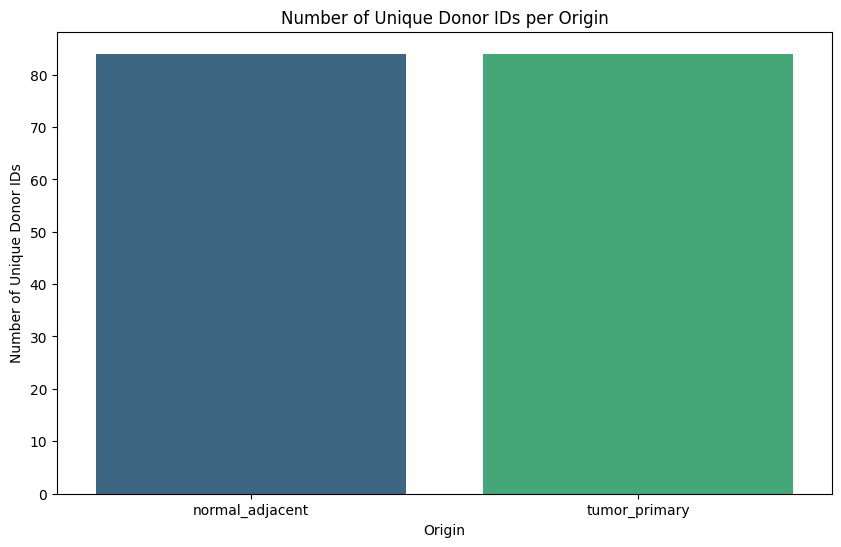

In [45]:
plt.figure(figsize=(10, 6))
sns.barplot(data=origin_counts, x='origin', y='count', palette='viridis')
plt.xlabel('Origin')
plt.ylabel('Number of Unique Donor IDs')
plt.title('Number of Unique Donor IDs per Origin')
plt.show()

In [46]:
df = paired_adata.obs#
origin_counts = df.groupby('disease')['donor_id'].nunique().reset_index()
origin_counts.columns = ['disease', 'count']

/tmp/ipykernel_2915359/3679065484.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  origin_counts = df.groupby('disease')['donor_id'].nunique().reset_index()


/tmp/ipykernel_2915359/3057708053.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=origin_counts, x='disease', y='count', palette='viridis')


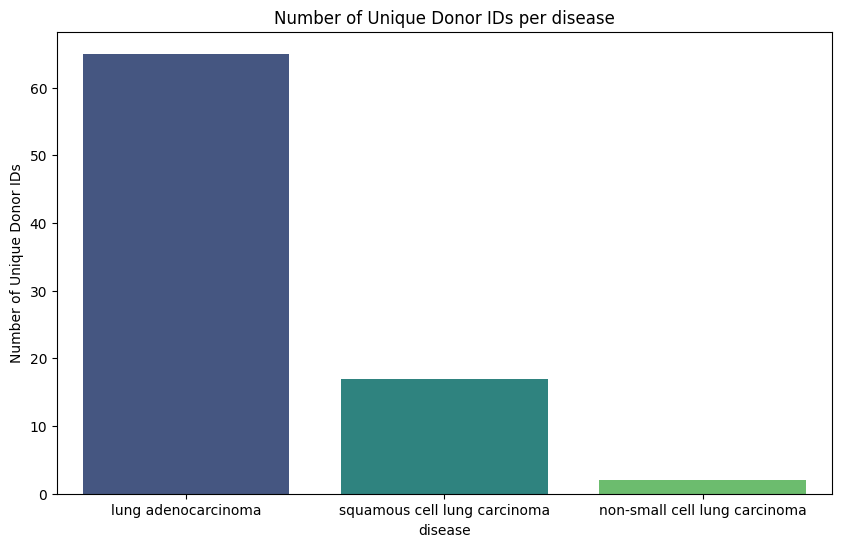

In [47]:
plt.figure(figsize=(10, 6))
sns.barplot(data=origin_counts, x='disease', y='count', palette='viridis')
plt.xlabel('disease')
plt.ylabel('Number of Unique Donor IDs')
plt.title('Number of Unique Donor IDs per disease')
plt.show()

In [60]:
paired_adata.obs.disease.value_counts()

disease
lung adenocarcinoma              349139
squamous cell lung carcinoma      95103
non-small cell lung carcinoma     20834
Name: count, dtype: int64

In [61]:
paired_adata.obs.tumor_stage.value_counts()

tumor_stage
early       407421
advanced     57655
Name: count, dtype: int64

In [62]:
paired_adata.obs.sex.value_counts()

sex
female    233188
male      231888
Name: count, dtype: int64

In [63]:
paired_adata.obs.origin.value_counts()

origin
tumor_primary      260782
normal_adjacent    204294
Name: count, dtype: int64

In [64]:
paired_adata.obs.dataset.value_counts()

dataset
UKIM-V-2                                            78529
Leader_Merad_2021_10x_3p_v2_beads                   77020
He_Fan_2021                                         68546
Kim_Lee_2020                                        46967
Leader_Merad_2021_10x_3p_v2_digest-deadcell_cite    43966
Leader_Merad_2021_10x_3p_v2_beads_cite              41045
Lambrechts_Thienpont_2018_6149v2                    32373
Lambrechts_Thienpont_2018_6653                      16653
UKIM-V                                              16262
Goveia_Carmeliet_2020                               14605
Leader_Merad_2021_10x_5p_v1_CD2                     13419
Guo_Zhang_2018                                       5924
Leader_Merad_2021_10x_3p_v2_sort                     4615
Leader_Merad_2021_10x_5p_v1_beads                    3599
Lambrechts_Thienpont_2018_6149v1                     1553
Name: count, dtype: int64

In [65]:
paired_adata

AnnData object with n_obs × n_vars = 465076 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts',

## Create layer Log 1pnorm 

In [112]:
paired_adata.layers["log1p_norm"] = paired_adata.X.copy()
sc.pp.normalize_total(paired_adata, target_sum=1e6, layer="log1p_norm")
sc.pp.log1p(paired_adata, base=6, layer="log1p_norm")

In [113]:
paired_adata

AnnData object with n_obs × n_vars = 465076 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts',

## Checking for XIST & RPS4Y1 in male and female

In [89]:
paired_adata.var_names = paired_adata.var.feature_name

/home/kvalem/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:864: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', 'A2ML1']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


/home/kvalem/.conda/envs/crc_atlas/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/kvalem/.conda/envs/crc_atlas/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/home/kvalem/.conda/envs/crc_atlas/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/kvalem/.conda/envs/crc_atlas/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter h

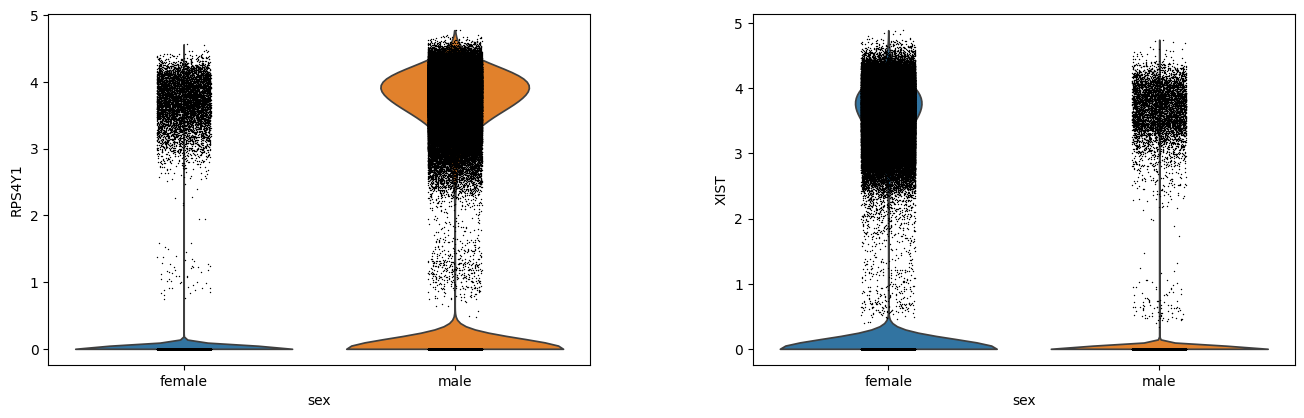

In [114]:


# Now, generate the plot and save it
sc.pl.violin(paired_adata, ["RPS4Y1", "XIST"], use_raw=False, groupby="sex", layer="log1p_norm")#, save="_xy_check.png")

In [137]:
rps4y1_cells = paired_adata[:, paired_adata.var_names == "RPS4Y1"].X > 0

# Subset the adata object to only those cells
rps4y1_paired_adata_subset = paired_adata[rps4y1_cells, :]

In [138]:
rps4y1_paired_adata_subset.obs.sex.value_counts()

sex
male      141044
female      6909
Name: count, dtype: int64

In [128]:
xist_cells = paired_adata[:, paired_adata.var_names == "XIST"].X > 0

# Subset the adata object to only those cells
xist_paired_adata_subset = paired_adata[xist_cells, :]

In [129]:
xist_paired_adata_subset.obs.sex.value_counts()

sex
female    105329
male        5867
Name: count, dtype: int64

In [135]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [140]:
rps4y1_paired_adata_subset.obs.groupby(["sex","donor_id"]).count()

/tmp/ipykernel_2915359/1444904727.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rps4y1_paired_adata_subset.obs.groupby(["sex","donor_id"]).count()


sample  uicc_stage  ever_smoker  \
sex    donor_id                                                              
female Goveia_Carmeliet_2020_patient_40         0           0            0   
       Goveia_Carmeliet_2020_patient_41         0           0            0   
       Goveia_Carmeliet_2020_patient_42         0           0            0   
       Goveia_Carmeliet_2020_patient_50         1           1            1   
       Guo_Zhang_2018_P0616P                    0           0            0   
       Guo_Zhang_2018_P0617                     0           0            0   
       Guo_Zhang_2018_P0729                     2           2            2   
       Guo_Zhang_2018_P0913                     0           0            0   
       Guo_Zhang_2018_P1010                     7           7            7   
       Guo_Zhang_2018_P1011                    39          39           39   
       Guo_Zhang_2018_P1120                     0           0            0   
       Guo_Zhang_2018_P1219                     6           6            6   
       He_Fan_2021_P1                           6           6            6   
       He_Fan_2021_P2                           0           0            0   
       He_Fan_2021_P4                           0           0            0   
       Kim_Lee_2020_P0006                       0           0            0   
       Kim_Lee_2020_P0009                       0           0            0   
       Kim_Lee_2020_P0018                       0           0            0   
       Kim_Lee_2020_P0019                       0           0            0   
       Kim_Lee_2020_P0020                       0           0            0   
       Kim_Lee_2020_P0028                       0           0            0   
       Kim_Lee_2020_P0030                       0           0            0   
       Kim_Lee_2020_P0031                       0           0            0   
       Kim_Lee_2020_P0034                       0           0            0   
       Lambrechts_Thienpont_2018_6149v1_2       0           0            0   
       Lambrechts_Thienpont_2018_6149v2_3       0           0            0   
       Lambrechts_Thienpont_2018_6149v2_4      38          38           38   
       Lambrechts_Thienpont_2018_6149v2_5       0           0            0   
       Lambrechts_Thienpont_2018_6653_7         0           0            0   
       Lambrechts_Thienpont_2018_6653_8      4679        4679         4679   
       Leader_Merad_2021_370                    1           1            1   
       Leader_Merad_2021_371                    0           0            0   
       Leader_Merad_2021_377                    0           0            0   
       Leader_Merad_2021_378                    4           4            4   
       Leader_Merad_2021_403                    0           0            0   
       Leader_Merad_2021_406                 2096        2096         2096   
       Leader_Merad_2021_408                    0           0            0   
       Leader_Merad_2021_460                    0           0            0   
       Leader_Merad_2021_532                    0           0            0   
       Leader_Merad_2021_564                    1           1            1   
       Leader_Merad_2021_570                    0           0            0   
       Leader_Merad_2021_572                    0           0            0   
       Leader_Merad_2021_578                    1           1            1   
       Leader_Merad_2021_584                    0           0            0   
       Leader_Merad_2021_593                    2           2            2   
       Leader_Merad_2021_596                    0           0            0   
       Leader_Merad_2021_626                    1           1            1   
       Leader_Merad_2021_630                    0           0            0   
       Leader_Merad_2021_695                    2           2            2   
       Leader_Merad_2021_706                    0           0    

In [141]:
xist_paired_adata_subset.obs.groupby(["sex","donor_id"]).count()

/tmp/ipykernel_2915359/685883600.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  xist_paired_adata_subset.obs.groupby(["sex","donor_id"]).count()


sample  uicc_stage  ever_smoker  \
sex    donor_id                                                              
female Goveia_Carmeliet_2020_patient_40         0           0            0   
       Goveia_Carmeliet_2020_patient_41         0           0            0   
       Goveia_Carmeliet_2020_patient_42         0           0            0   
       Goveia_Carmeliet_2020_patient_45       601         601          601   
       Goveia_Carmeliet_2020_patient_46      2111        2111         2111   
       Goveia_Carmeliet_2020_patient_50      1098        1098         1098   
       Guo_Zhang_2018_P0616P                    0           0            0   
       Guo_Zhang_2018_P0729                   319         319          319   
       Guo_Zhang_2018_P0913                     0           0            0   
       Guo_Zhang_2018_P1010                   573         573          573   
       Guo_Zhang_2018_P1011                   504         504          504   
       Guo_Zhang_2018_P1118                   442         442          442   
       Guo_Zhang_2018_P1120                     0           0            0   
       Guo_Zhang_2018_P1202                   593         593          593   
       Guo_Zhang_2018_P1219                    66          66           66   
       He_Fan_2021_P1                        7371        7371         7371   
       He_Fan_2021_P2                           0           0            0   
       He_Fan_2021_P3                        4889        4889         4889   
       He_Fan_2021_P5                        2828        2828         2828   
       Kim_Lee_2020_P0008                    2448        2448         2448   
       Kim_Lee_2020_P0018                       0           0            0   
       Kim_Lee_2020_P0020                       0           0            0   
       Lambrechts_Thienpont_2018_6149v2_3       0           0            0   
       Lambrechts_Thienpont_2018_6149v2_4    4163        4163         4163   
       Lambrechts_Thienpont_2018_6149v2_5       0           0            0   
       Lambrechts_Thienpont_2018_6653_6         0           0            0   
       Lambrechts_Thienpont_2018_6653_7         0           0            0   
       Leader_Merad_2021_370                 1211        1211         1211   
       Leader_Merad_2021_378                 3725        3725         3725   
       Leader_Merad_2021_403                    0           0            0   
       Leader_Merad_2021_410                 3575        3575         3575   
       Leader_Merad_2021_458                  400         400          400   
       Leader_Merad_2021_464                    5           5            5   
       Leader_Merad_2021_514                 1337        1337         1337   
       Leader_Merad_2021_522                 3123        3123         3123   
       Leader_Merad_2021_532                    0           0            0   
       Leader_Merad_2021_564                 3800        3800         3800   
       Leader_Merad_2021_569                 1349        1349         1349   
       Leader_Merad_2021_578                 2137        2137         2137   
       Leader_Merad_2021_581                    0           0            0   
       Leader_Merad_2021_593                 1913        1913         1913   
       Leader_Merad_2021_596                    0           0            0   
       Leader_Merad_2021_626                 6410        6410         6410   
       Leader_Merad_2021_630                    0           0            0   
       Leader_Merad_2021_695                11517       11517        11517   
       Leader_Merad_2021_706                    0           0            0   
       Leader_Merad_2021_714                 1109        1109         1109   
       Leader_Merad_2021_729                 2101        2101         2101   
       UKIM-V-2_P4                           2434        2434         2434   
       UKIM-V-2_P5                           2712        2712    

These patients express X and Y realted chromosomes oposite to what they are labelled. 

* rps4y1 "Lambrechts_Thienpont_2018_6653_8", "Leader_Merad_2021_406"
* xist "Lambrechts_Thienpont_2018_6653_6", "Leader_Merad_2021_581"
- Option 1. Relabel as oposite (male & female) 
- Option 2. Remove to avoid mistakes




## Remove these donor id 

In [143]:
paired_adata_clean = paired_adata[~paired_adata.obs["donor_id"].isin(["Lambrechts_Thienpont_2018_6653_8", "Leader_Merad_2021_406", "Lambrechts_Thienpont_2018_6653_6", "Leader_Merad_2021_581"])]

In [144]:
paired_adata

AnnData object with n_obs × n_vars = 465076 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts',

In [145]:
paired_adata_clean

View of AnnData object with n_obs × n_vars = 442199 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'cell_type_neutro', 'cell_type_neutro_coarse', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_

In [146]:
rps4y1_cells = paired_adata_clean[:, paired_adata_clean.var_names == "RPS4Y1"].X > 0

# Subset the adata object to only those cells
rps4y1_paired_adata_subset = paired_adata_clean[rps4y1_cells, :]

In [147]:
rps4y1_paired_adata_subset.obs.sex.value_counts()

sex
male      141044
female       134
Name: count, dtype: int64

In [149]:
xist_cells = paired_adata_clean[:, paired_adata_clean.var_names == "XIST"].X > 0

# Subset the adata object to only those cells
xist_paired_adata_subset = paired_adata_clean[xist_cells, :]

In [150]:
xist_paired_adata_subset.obs.sex.value_counts()

sex
female    105329
male         408
Name: count, dtype: int64

In [151]:
rps4y1_paired_adata_subset.obs.groupby(["sex","donor_id"]).count()

/tmp/ipykernel_2915359/1444904727.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rps4y1_paired_adata_subset.obs.groupby(["sex","donor_id"]).count()


sample  uicc_stage  ever_smoker  \
sex    donor_id                                                              
female Goveia_Carmeliet_2020_patient_40         0           0            0   
       Goveia_Carmeliet_2020_patient_41         0           0            0   
       Goveia_Carmeliet_2020_patient_42         0           0            0   
       Goveia_Carmeliet_2020_patient_50         1           1            1   
       Guo_Zhang_2018_P0616P                    0           0            0   
       Guo_Zhang_2018_P0617                     0           0            0   
       Guo_Zhang_2018_P0729                     2           2            2   
       Guo_Zhang_2018_P0913                     0           0            0   
       Guo_Zhang_2018_P1010                     7           7            7   
       Guo_Zhang_2018_P1011                    39          39           39   
       Guo_Zhang_2018_P1120                     0           0            0   
       Guo_Zhang_2018_P1219                     6           6            6   
       He_Fan_2021_P1                           6           6            6   
       He_Fan_2021_P2                           0           0            0   
       He_Fan_2021_P4                           0           0            0   
       Kim_Lee_2020_P0006                       0           0            0   
       Kim_Lee_2020_P0009                       0           0            0   
       Kim_Lee_2020_P0018                       0           0            0   
       Kim_Lee_2020_P0019                       0           0            0   
       Kim_Lee_2020_P0020                       0           0            0   
       Kim_Lee_2020_P0028                       0           0            0   
       Kim_Lee_2020_P0030                       0           0            0   
       Kim_Lee_2020_P0031                       0           0            0   
       Kim_Lee_2020_P0034                       0           0            0   
       Lambrechts_Thienpont_2018_6149v1_2       0           0            0   
       Lambrechts_Thienpont_2018_6149v2_3       0           0            0   
       Lambrechts_Thienpont_2018_6149v2_4      38          38           38   
       Lambrechts_Thienpont_2018_6149v2_5       0           0            0   
       Lambrechts_Thienpont_2018_6653_7         0           0            0   
       Leader_Merad_2021_370                    1           1            1   
       Leader_Merad_2021_371                    0           0            0   
       Leader_Merad_2021_377                    0           0            0   
       Leader_Merad_2021_378                    4           4            4   
       Leader_Merad_2021_403                    0           0            0   
       Leader_Merad_2021_408                    0           0            0   
       Leader_Merad_2021_460                    0           0            0   
       Leader_Merad_2021_532                    0           0            0   
       Leader_Merad_2021_564                    1           1            1   
       Leader_Merad_2021_570                    0           0            0   
       Leader_Merad_2021_572                    0           0            0   
       Leader_Merad_2021_578                    1           1            1   
       Leader_Merad_2021_584                    0           0            0   
       Leader_Merad_2021_593                    2           2            2   
       Leader_Merad_2021_596                    0           0            0   
       Leader_Merad_2021_626                    1           1            1   
       Leader_Merad_2021_630                    0           0            0   
       Leader_Merad_2021_695                    2           2            2   
       Leader_Merad_2021_706                    0           0            0   
       Leader_Merad_2021_729                    1           1            1   
       UKIM-V-2_P4                              1           1    

In [152]:
xist_paired_adata_subset.obs.groupby(["sex","donor_id"]).count()

/tmp/ipykernel_2915359/685883600.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  xist_paired_adata_subset.obs.groupby(["sex","donor_id"]).count()


sample  uicc_stage  ever_smoker  \
sex    donor_id                                                              
female Goveia_Carmeliet_2020_patient_40         0           0            0   
       Goveia_Carmeliet_2020_patient_41         0           0            0   
       Goveia_Carmeliet_2020_patient_42         0           0            0   
       Goveia_Carmeliet_2020_patient_45       601         601          601   
       Goveia_Carmeliet_2020_patient_46      2111        2111         2111   
       Goveia_Carmeliet_2020_patient_50      1098        1098         1098   
       Guo_Zhang_2018_P0616P                    0           0            0   
       Guo_Zhang_2018_P0729                   319         319          319   
       Guo_Zhang_2018_P0913                     0           0            0   
       Guo_Zhang_2018_P1010                   573         573          573   
       Guo_Zhang_2018_P1011                   504         504          504   
       Guo_Zhang_2018_P1118                   442         442          442   
       Guo_Zhang_2018_P1120                     0           0            0   
       Guo_Zhang_2018_P1202                   593         593          593   
       Guo_Zhang_2018_P1219                    66          66           66   
       He_Fan_2021_P1                        7371        7371         7371   
       He_Fan_2021_P2                           0           0            0   
       He_Fan_2021_P3                        4889        4889         4889   
       He_Fan_2021_P5                        2828        2828         2828   
       Kim_Lee_2020_P0008                    2448        2448         2448   
       Kim_Lee_2020_P0018                       0           0            0   
       Kim_Lee_2020_P0020                       0           0            0   
       Lambrechts_Thienpont_2018_6149v2_3       0           0            0   
       Lambrechts_Thienpont_2018_6149v2_4    4163        4163         4163   
       Lambrechts_Thienpont_2018_6149v2_5       0           0            0   
       Lambrechts_Thienpont_2018_6653_7         0           0            0   
       Leader_Merad_2021_370                 1211        1211         1211   
       Leader_Merad_2021_378                 3725        3725         3725   
       Leader_Merad_2021_403                    0           0            0   
       Leader_Merad_2021_410                 3575        3575         3575   
       Leader_Merad_2021_458                  400         400          400   
       Leader_Merad_2021_464                    5           5            5   
       Leader_Merad_2021_514                 1337        1337         1337   
       Leader_Merad_2021_522                 3123        3123         3123   
       Leader_Merad_2021_532                    0           0            0   
       Leader_Merad_2021_564                 3800        3800         3800   
       Leader_Merad_2021_569                 1349        1349         1349   
       Leader_Merad_2021_578                 2137        2137         2137   
       Leader_Merad_2021_593                 1913        1913         1913   
       Leader_Merad_2021_596                    0           0            0   
       Leader_Merad_2021_626                 6410        6410         6410   
       Leader_Merad_2021_630                    0           0            0   
       Leader_Merad_2021_695                11517       11517        11517   
       Leader_Merad_2021_706                    0           0            0   
       Leader_Merad_2021_714                 1109        1109         1109   
       Leader_Merad_2021_729                 2101        2101         2101   
       UKIM-V-2_P4                           2434        2434         2434   
       UKIM-V-2_P5                           2712        2712         2712   
       UKIM-V-2_P6                              0           0            0   
       UKIM-V-2_P7                           1960        1960    

/home/kvalem/.conda/envs/crc_atlas/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/kvalem/.conda/envs/crc_atlas/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/home/kvalem/.conda/envs/crc_atlas/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/kvalem/.conda/envs/crc_atlas/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter h

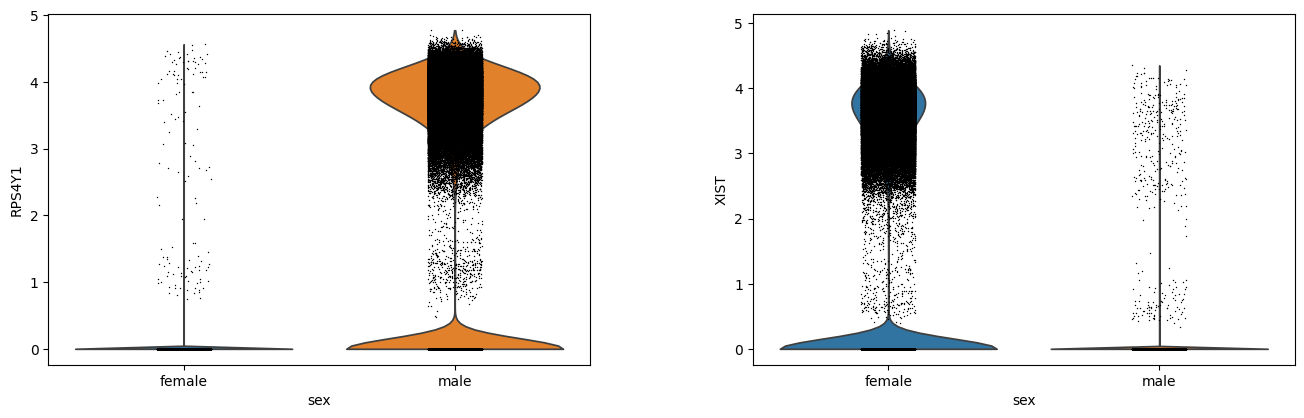

In [153]:
# Now, generate the plot and save it
sc.pl.violin(paired_adata_clean, ["RPS4Y1", "XIST"], use_raw=False, groupby="sex", layer="log1p_norm", save="_xy_check.png")

## SUMMARY 
- We used the sex annotation that was given in the respective datasets
- These annotations were confirmed by our analysis, as no Ygenes were in the female cohort. 

### 04.Compute pseudobulk

In [156]:
path = "/data/projects/2023/LCBiome/nsclc_gender_atlas_tmp/out/011_analysis_paired_remove_xy/pseudobulk/"

In [154]:
# Get pseudo-bulk profile
pdata = dc.get_pseudobulk(
    paired_adata_clean,
    sample_col='sample',
    groups_col='donor_id',
    layer='count',
    min_cells=0,
    min_counts=0
)

/home/kvalem/.conda/envs/crc_atlas/lib/python3.11/site-packages/decoupler/utils_anndata.py:181: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cols = obs.groupby([sample_col, groups_col]).apply(lambda x: x.apply(lambda y: len(y.unique()) == 1)).all(0)
/home/kvalem/.local/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [159]:
pdata.obs["age"] = pdata.obs["age"].astype("float64")
pdata.obs["is_primary_data"] = pdata.obs["is_primary_data"].astype(bool)


In [ ]:
#pdata.write_h5ad(f"{path}/out/010_analysis_paired_include_guon/tables/input/pdata.h5ad")

In [ ]:
#pdata = sc.read_h5ad(f"{path}/out/008_analysis_paired_luad/tables/input/pdata.h5ad")

In [160]:
pdata

AnnData object with n_obs × n_vars = 233 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'doublet_status', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'suspension_type', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'psbulk_n_cells', 'psbulk_counts'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    layers: 'psbulk_props'

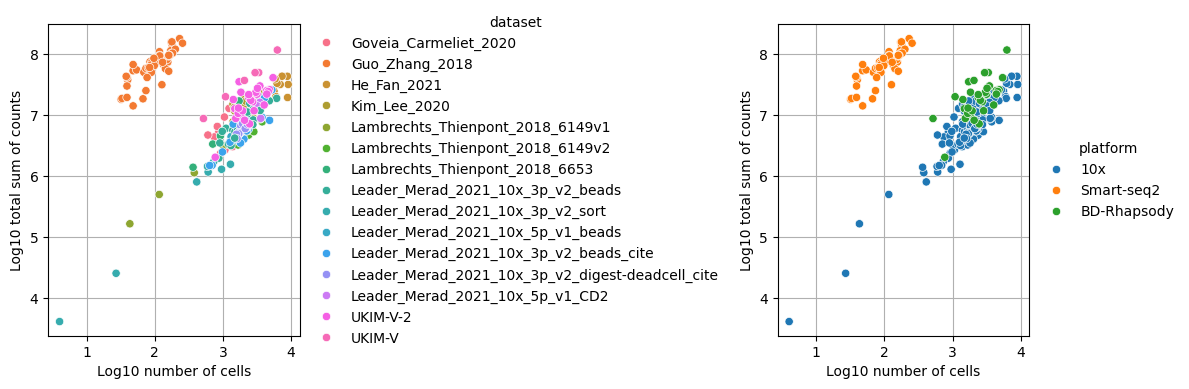

In [161]:
dc.plot_psbulk_samples(pdata, groupby=['dataset', 'platform'], figsize=(12, 4))

In [ ]:
#pdata = pdata[pdata.obs["dataset"]!="Guo_Zhang_2018"] ## SMART SEQ 

In [ ]:
#pdata

In [ ]:
#dc.plot_psbulk_samples(pdata, groupby=['dataset', 'platform'], figsize=(12, 4))

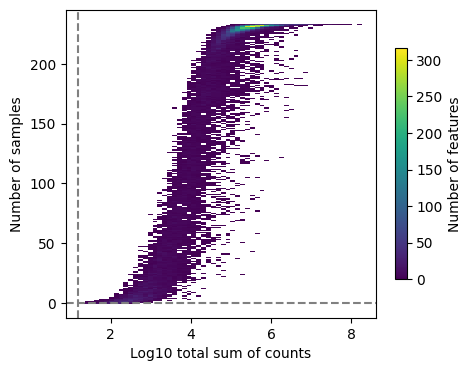

In [162]:
dc.plot_filter_by_expr(pdata, group='sample', min_count=10, min_total_count=15)

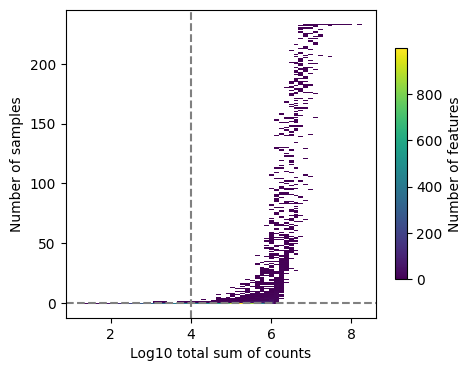

In [163]:
dc.plot_filter_by_expr(pdata, group='sample', large_n=100,min_prop=0.9, min_count=5000, min_total_count=10000)

I set this threshold for the DS analysis to avoid havinh zero-inflated data

In [164]:
# Obtain genes that pass the thresholds 
genes = dc.filter_by_expr(pdata, group='sample', min_count=5000, min_total_count=10000)

# Filter by these genes
pdata = pdata[:, genes].copy()
pdata

AnnData object with n_obs × n_vars = 233 × 1893
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'doublet_status', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'suspension_type', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'psbulk_n_cells', 'psbulk_counts'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    layers: 'psbulk_props'

In [165]:
pdata.layers["counts"] = pdata.X

In [166]:
scales_counts = sc.pp.normalize_total(pdata, target_sum=None, inplace=False)
# log1p transform
pdata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

In [167]:
pdata

AnnData object with n_obs × n_vars = 233 × 1893
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'doublet_status', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'suspension_type', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'psbulk_n_cells', 'psbulk_counts'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    layers: 'psbulk_props', 'counts', 'log1p_norm'

In [168]:
### Samplesheet
samplesheet = pdata.obs.copy()
samplesheet["sample"]=samplesheet.index
samplesheet.reset_index(inplace=True)

In [169]:
samplesheet.to_csv(f"{path}samplesheet.csv", index=False)
samplesheet.to_csv(f"{path}samplesheet.tsv", index=False, sep = "\t")

In [170]:
bulk_df = pdata.to_df().T

In [171]:
### Raw counts
bulk_df = pdata.to_df().T
#bulk_df["gene_id"]=bulk_df.index
bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")

In [172]:
bulk_df.to_csv(f"{path}counts.csv")    

In [173]:
### log1p_norm counts
pdata_log1p_norm = pd.DataFrame(pdata.layers["log1p_norm"], 
    pdata.to_df().index, 
    pdata.to_df().columns)
bulk_df = pdata_log1p_norm.T
#bulk_df["gene_id"]=bulk_df.index
bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")
bulk_df.to_csv(f"{path}log1p_norm_counts.csv")    

### 0.4 Create counts and samplesheet independent for tumor and normal for DESEQ2 

In [174]:
pdata_normal = pdata[pdata.obs["origin"]=="normal_adjacent"]
pdata_tumor = pdata[pdata.obs["origin"]=="tumor_primary"]

In [175]:
pdata_normal

View of AnnData object with n_obs × n_vars = 106 × 1893
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'doublet_status', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'suspension_type', 'assay_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'psbulk_n_cells', 'psbulk_counts'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    layers: 'psbulk_props', 'counts', 'log1p_norm'

In [177]:
pdata_list = [pdata_normal,pdata_tumor]
pdata_list_name = ["normal","tumor"]

for index, dataframe in enumerate(pdata_list):
    print(pdata_list_name[index])
    # Perform the operations
    samplesheet = dataframe.obs.copy()
    samplesheet["sample"] = samplesheet.index
    samplesheet.reset_index(inplace=True)
  
    samplesheet.to_csv(f"{path}samplesheet_{pdata_list_name[index]}.csv", index=False)
    samplesheet.to_csv(f"{path}samplesheet_{pdata_list_name[index]}.tsv", index=False, sep="\t")


    ### Raw counts
    bulk_df = dataframe.to_df().T
    #bulk_df["gene_id"]=bulk_df.index
    bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")
    bulk_df.to_csv(f"{path}counts_{pdata_list_name[index]}.csv")  
    ### log1p_norm counts
    pdata_log1p_norm = pd.DataFrame(dataframe.layers["log1p_norm"], 
        dataframe.to_df().index, 
        dataframe.to_df().columns)
    bulk_df = pdata_log1p_norm.T
    #bulk_df["gene_id"]=bulk_df.index
    bulk_df.columns = bulk_df.columns.str.replace("[.-]", "_").str.replace(" ", "_")
    bulk_df.to_csv(f"{path}/log1p_norm_counts_{pdata_list_name[index]}.csv")    

normal
tumor
